In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from linearmodels.panel import PanelOLS, compare 
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


## Bases de dados

In [109]:
df_empreend = pd.read_csv('../dados/tratados/simu_carteira_empreendimentos.csv')
df_agrup_munic_ano = pd.read_csv('../dados/tratados/agrupamento_empreend_acidentes_por_municipio_e_ano_sem_nulos.csv')

In [126]:
print(df_agrup_munic_ano.columns.tolist())
df_agrup_munic_ano.head()

['Código IBGE', 'ano', 'vlr_investimento', 'pop_beneficiada', 'num_total_empreendimentos', 'aux_emp_implantacao', 'aux_emp_implantacao_vlr_investimento', 'aux_emp_pavimentacao', 'aux_emp_pavimentacao_vlr_investimento', 'aux_emp_refrota', 'aux_emp_refrota_vlr_investimento', 'aux_emp_sinalizacao', 'aux_emp_sinalizacao_vlr_investimento', 'aux_emp_calcamento', 'aux_emp_calcamento_vlr_investimento', 'aux_emp_ciclovia', 'aux_emp_ciclovia_vlr_investimento', 'aux_emp_corredor', 'aux_emp_corredor_vlr_investimento', 'aux_emp_drenagem', 'aux_emp_drenagem_vlr_investimento', 'aux_emp_ferrovia', 'aux_emp_ferrovia_vlr_investimento', 'aux_emp_transporte', 'aux_emp_transporte_vlr_investimento', 'aux_emp_brt', 'aux_emp_brt_vlr_investimento', 'aux_emp_vlt', 'aux_emp_vlt_vlr_investimento', 'aux_emp_qualificacao', 'aux_emp_qualificacao_vlr_investimento', 'aux_emp_mobilidade_urbana', 'aux_emp_mobilidade_urbana_vlr_investimento', 'aux_emp_aquisicao', 'aux_emp_aquisicao_vlr_investimento', 'aux_emp_polongament

,Código IBGE,ano,vlr_investimento,pop_beneficiada,num_total_empreendimentos,aux_emp_implantacao,aux_emp_implantacao_vlr_investimento,aux_emp_pavimentacao,aux_emp_pavimentacao_vlr_investimento,aux_emp_refrota,...,taxa_mun_motociclista_feridos,taxa_mun_automovel_feridos,taxa_mun_veiculo_pesado_feridos,taxa_mun_onibus_feridos,taxa_mun_outros_feridos,Populacao,taxa_mun_triciclo_mortes,taxa_mun_caminhonete_mortes,taxa_mun_triciclo_feridos,taxa_mun_caminhonete_feridos
0,1100015.0,2011.0,1530000.00,1841.0,2,0,0.0,2,1530000.00,0,...,0.000000,0.000000,0.0,0.000000,0.000000,24228.0,0.0,0.0,0.0,0.0
1,1100023.0,2012.0,1787781.82,2087.0,2,0,0.0,0,0.00,0,...,0.177903,0.002156,0.0,0.000000,0.000000,92747.0,0.0,0.0,0.0,0.0
2,1100023.0,2014.0,36842105.26,43512.0,1,0,0.0,1,36842105.26,0,...,0.055415,0.000000,0.0,0.000972,0.000000,102860.0,0.0,0.0,0.0,0.0
3,1100031.0,2011.0,265850.00,306.0,1,0,0.0,1,265850.00,0,...,0.000000,0.000000,0.0,0.000000,0.000000,6221.0,0.0,0.0,0.0,0.0
4,1100049.0,2010.0,2821324.40,3343.0,3,0,0.0,2,2290724.40,0,...,0.006363,0.000000,0.0,0.000000,0.001273,78574.0,0.0,0.0,0.0,0.0


## 

## Seleciona variáveis para os dados em painel

**Eixos:**

eixo transversal = $Município$

eixo temporal = $ano$

**Variáveis dependentes:**

$y_1=total\_mortes$

$y_2=total\_feridos$

**Variáveis independentes:**

$X =$ variáveis numéricas excluindo colunas que tornam a matriz LD

Variáveis explicativas escolhidas, a princípio,  de forma arbitrária:

In [111]:

selected_columns = df_agrup_munic_ano.select_dtypes(include='number').columns

df_panel = df_agrup_munic_ano[selected_columns].copy()
df_panel = df_panel.loc[:,(df_panel != 0).any(axis=0)] #remove colunas zeradas pra não dar problema de rank no PanelOLS
df_panel['Código IBGE'] = df_panel['Código IBGE'].astype('category')
df_panel.set_index(['Código IBGE', 'ano'], inplace=True)

selected_columns = df_panel.columns.tolist()
x_columns_selected = df_panel[selected_columns].columns[~df_panel[selected_columns].columns.isin(['Código IBGE', 'ano', 'total_mortes', 'total_feridos'])].tolist()

X_old = df_panel[x_columns_selected]
#####  resolver problema de posto da matriz LD
Q, R = np.linalg.qr(X_old.T)
# Selecionar colunas independentes
selected_columns = np.where(np.where(np.abs(R.diagonal()) > 1e-10)[0])[0]

# Criar um novo DataFrame com as colunas independentes
X = X_old.iloc[:, selected_columns]
x_columns_numeric = X.columns.tolist()
print(f"Rank da matriz resultante: {np.linalg.matrix_rank(X.values)}")
print(f"Colunas selecionadas: {X.columns.tolist()}")
print(f"Colunas removidas: {X_old.columns[~X_old.columns.isin(X.columns)].tolist()}\n")
#####

# Adicionar constante
X = sm.add_constant(X).astype(float)

y_mortes = df_panel['total_mortes'].astype(float)
y_feridos = df_panel['total_feridos'].astype(float)
X

Rank da matriz resultante: 78
Colunas selecionadas: ['pop_beneficiada', 'num_total_empreendimentos', 'aux_emp_implantacao', 'aux_emp_implantacao_vlr_investimento', 'aux_emp_pavimentacao', 'aux_emp_pavimentacao_vlr_investimento', 'aux_emp_refrota', 'aux_emp_refrota_vlr_investimento', 'aux_emp_sinalizacao', 'aux_emp_sinalizacao_vlr_investimento', 'aux_emp_calcamento', 'aux_emp_calcamento_vlr_investimento', 'aux_emp_ciclovia', 'aux_emp_ciclovia_vlr_investimento', 'aux_emp_corredor', 'aux_emp_corredor_vlr_investimento', 'aux_emp_drenagem', 'aux_emp_drenagem_vlr_investimento', 'aux_emp_ferrovia', 'aux_emp_ferrovia_vlr_investimento', 'aux_emp_transporte', 'aux_emp_transporte_vlr_investimento', 'aux_emp_brt', 'aux_emp_brt_vlr_investimento', 'aux_emp_vlt', 'aux_emp_vlt_vlr_investimento', 'aux_emp_qualificacao', 'aux_emp_qualificacao_vlr_investimento', 'aux_emp_mobilidade_urbana', 'aux_emp_mobilidade_urbana_vlr_investimento', 'aux_emp_aquisicao', 'aux_emp_aquisicao_vlr_investimento', 'aux_emp_p

const  pop_beneficiada  num_total_empreendimentos  \
Código IBGE ano                                                         
1100015.0   2011.0    1.0           1841.0                        2.0   
1100023.0   2012.0    1.0           2087.0                        2.0   
            2014.0    1.0          43512.0                        1.0   
1100031.0   2011.0    1.0            306.0                        1.0   
1100049.0   2010.0    1.0           3343.0                        3.0   
...                   ...              ...                        ...   
5300108.0   2015.0    1.0          20665.0                        7.0   
            2016.0    1.0           3678.0                        3.0   
            2017.0    1.0           5614.0                        5.0   
            2018.0    1.0          50705.0                        8.0   
            2019.0    1.0           1268.0                        1.0   

                    aux_emp_implantacao  aux_emp_implantacao_vlr_investimento  \
Código IBGE ano                                                                 
1100015.0   2011.0                  0.0                                  0.00   
1100023.0   2012.0                  0.0                                  0.00   
            2014.0                  0.0                                  0.00   
1100031.0   2011.0                  0.0                                  0.00   
1100049.0   2010.0                  0.0                                  0.00   
...                                 ...                                   ...   
5300108.0   2015.0                  1.0                            2745666.67   
            2016.0                  0.0                                  0.00   
            2017.0                  2.0                            2407189.26   
            2018.0                  2.0                           38486221.13   
            2019.0                  0.0                                  0.00   

                    aux_emp_pavimentacao  \
Código IBGE ano                            
1100015.0   2011.0                   2.0   
1100023.0   2012.0                   0.0   
            2014.0                   1.0   
1100031.0   2011.0                   1.0   
1100049.0   2010.0                   2.0   
...                                  ...   
5300108.0   2015.0                   3.0   
            2016.0                   3.0   
            2017.0                   1.0   
            2018.0                   3.0   
            2019.0                   1.0   

                    aux_emp_pavimentacao_vlr_investimento  aux_emp_refrota  \
Código IBGE ano                                                              
1100015.0   2011.0                             1530000.00              0.0   
1100023.0   2012.0                                   0.00              0.0   
            2014.0                            36842105.26              0.0   
1100031.0   2011.0                              265850.00              0.0   
1100049.0   2010.0                             2290724.40              0.0   
...                                                   ...              ...   
5300108.0   2015.0                             2785984.00              0.0   
            2016.0                             2988382.00              0.0   
            2017.0                              988588.59              0.0   
            2018.0                             3725213.98              0.0   
            2019.0                             1020756.76              0.0   

                    aux_emp_refrota_vlr_investimento  aux_emp_sinalizacao  \
Código IBGE ano                                                             
1100015.0   2011.0                               0.0                  0.0   
1100023.0   2012.0                               0.0                  0.0   
            2014.0                               0.0                  0.0   
1100031.0   2011.0                         

## Efeitos Fixos

**Modelo simplificado**

$$y_{it} = \gamma_t + \beta'x_{it} + \epsilon_{it}$$

$$i = Município, \quad t = ano$$

https://bashtage.github.io/linearmodels/panel/panel/linearmodels.panel.model.PanelOLS.html


In [112]:
# Selecionar variáveis dependentes e independentes
X = df_panel[[*x_columns_numeric]]
y_mortes = df_panel['total_mortes'].astype(float)
y_feridos = df_panel['total_feridos'].astype(float)

# Adicionar constante
X = sm.add_constant(X).astype(float)

# Modelo de Efeitos Fixos para Mortes
fe_model_mortes = PanelOLS(y_mortes, X, entity_effects=True)
fe_model_mortes = fe_model_mortes.fit()
fe_model_mortes.summary

Dep. Variable:,total_mortes,R-squared:,0.9084
Estimator:,PanelOLS,R-squared (Between):,0.6028
No. Observations:,20700,R-squared (Within):,0.9084
Date:,"Sun, Jun 02 2024",R-squared (Overall):,0.6714
Time:,15:26:51,Log-likelihood,-5.9e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,1955.3
Entities:,5244,P-value,0.0000
Avg Obs:,3.9474,Distribution:,"F(78,15378)"
Min Obs:,1.0000,,
Max Obs:,10.0000,F-statistic (robust):,1955.3


In [113]:
# Modelo de Efeitos Fixos para Feridos
fe_model_feridos = PanelOLS(y_feridos, X, entity_effects=True)
fe_model_feridos = fe_model_feridos.fit()
fe_model_feridos.summary

Dep. Variable:,total_feridos,R-squared:,0.2334
Estimator:,PanelOLS,R-squared (Between):,0.2468
No. Observations:,20700,R-squared (Within):,0.2334
Date:,"Sun, Jun 02 2024",R-squared (Overall):,0.3035
Time:,15:26:52,Log-likelihood,-1.195e+05
Cov. Estimator:,Unadjusted,,
,,F-statistic:,60.025
Entities:,5244,P-value,0.0000
Avg Obs:,3.9474,Distribution:,"F(78,15378)"
Min Obs:,1.0000,,
Max Obs:,10.0000,F-statistic (robust):,60.025


### Resíduos

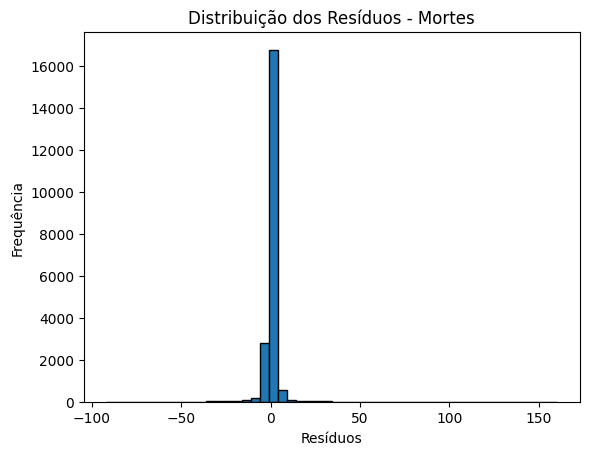

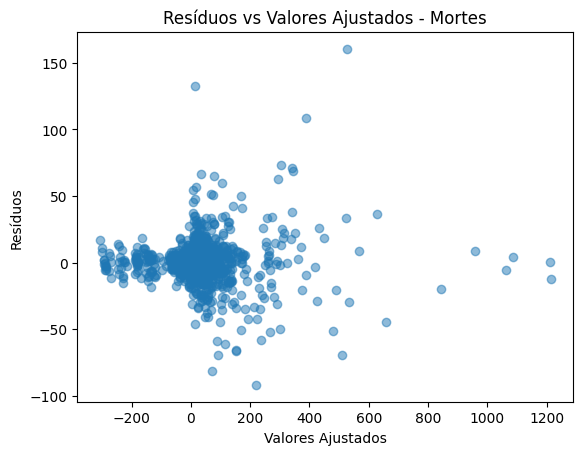

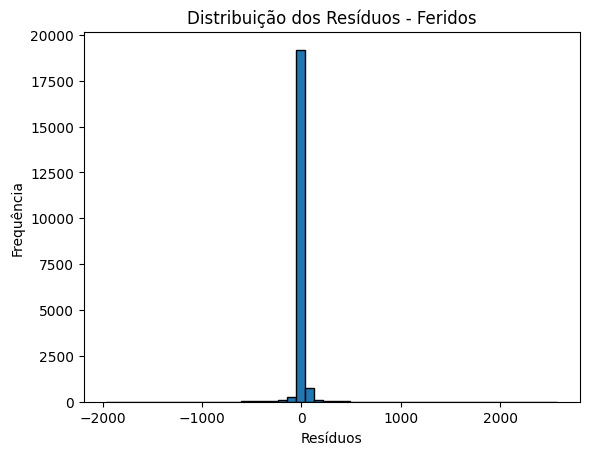

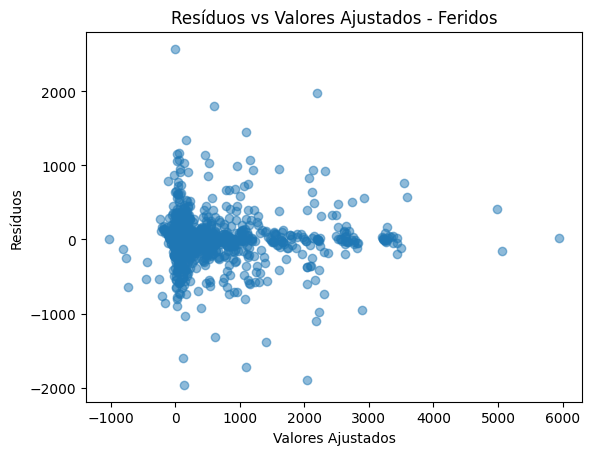

In [114]:

# Obter os resíduos do modelo de mortes
residuos_mortes = fe_model_mortes.resids

# Plotar um histograma dos resíduos
plt.hist(residuos_mortes, bins=50, edgecolor='k')
plt.title('Distribuição dos Resíduos - Mortes')
plt.xlabel('Resíduos')
plt.ylabel('Frequência')
plt.show()

# Plotar os resíduos vs valores ajustados
plt.scatter(fe_model_mortes.fitted_values, residuos_mortes, alpha=0.5)
plt.title('Resíduos vs Valores Ajustados - Mortes')
plt.xlabel('Valores Ajustados')
plt.ylabel('Resíduos')
plt.show()

# Repetir para os resíduos do modelo de feridos
residuos_feridos = fe_model_feridos.resids

# Plotar um histograma dos resíduos
plt.hist(residuos_feridos, bins=50, edgecolor='k')
plt.title('Distribuição dos Resíduos - Feridos')
plt.xlabel('Resíduos')
plt.ylabel('Frequência')
plt.show()

# Plotar os resíduos vs valores ajustados
plt.scatter(fe_model_feridos.fitted_values, residuos_feridos, alpha=0.5)
plt.title('Resíduos vs Valores Ajustados - Feridos')
plt.xlabel('Valores Ajustados')
plt.ylabel('Resíduos')
plt.show()


#### Teste de Breusch-Pagan para heteroscedasticidade

$H_0: Homoscedástico$

In [115]:
model_mortes = sm.OLS(y_mortes, X).fit()

# Realizando o teste de Breusch-Pagan para mortes
bp_test_mortes = het_breuschpagan(model_mortes.resid, model_mortes.model.exog)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print("Breusch-Pagan Test for Total Mortes:")
print(dict(zip(labels, bp_test_mortes)))

# Ajustando o modelo com statsmodels para total de feridos
model_feridos = sm.OLS(y_feridos, X).fit()

# Realizando o teste de Breusch-Pagan para feridos
bp_test_feridos = het_breuschpagan(model_feridos.resid, model_feridos.model.exog)
print("Breusch-Pagan Test for Total Feridos:")
print(dict(zip(labels, bp_test_feridos)))

Breusch-Pagan Test for Total Mortes:
{'LM Statistic': 4586.859977683064, 'LM-Test p-value': 0.0, 'F-Statistic': 75.25760984179084, 'F-Test p-value': 0.0}
Breusch-Pagan Test for Total Feridos:
{'LM Statistic': 5460.593124122152, 'LM-Test p-value': 0.0, 'F-Statistic': 94.72985510832731, 'F-Test p-value': 0.0}


### Resíduos por efeito de munícipio ou ano 

In [116]:
df_aux_var = df_panel.copy()
residuos_mortes = fe_model_mortes.resids
df_aux_var = df_aux_var.merge(fe_model_mortes.resids, how='left', on=['Código IBGE', 'ano'], ).reset_index()
df_aux_var.rename(columns={'residual':'residuos_mortes'}, inplace=True)

# Agrupar e plotar resíduos médios por ano e municipio
residuos_por_ano = df_aux_var.groupby('ano')['residuos_mortes'].mean()
residuos_por_municipio = df_aux_var.groupby('Código IBGE')['residuos_mortes'].mean()

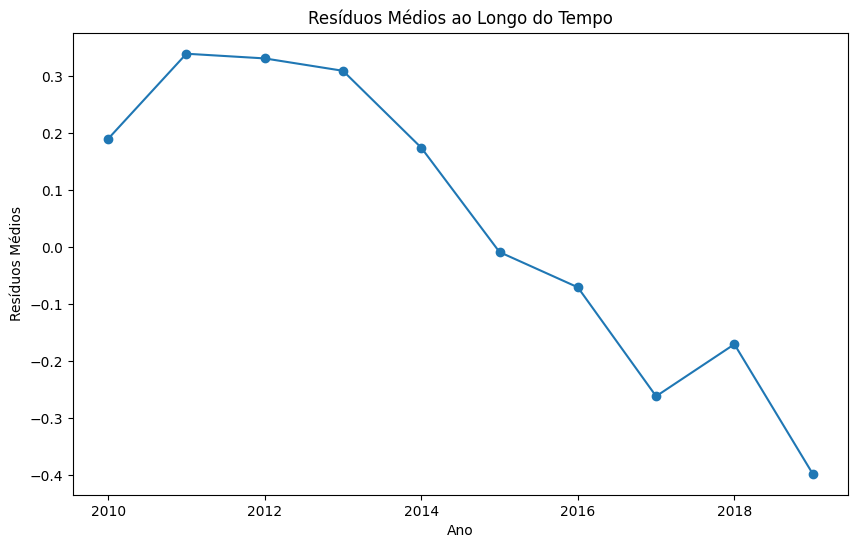

           LM p-value      F p-value
2011.0  7.690802e-141  5.621564e-249
2012.0  1.183310e-149   0.000000e+00
2014.0  1.532044e-297   0.000000e+00
2010.0  3.786562e-240   0.000000e+00
2013.0  2.851840e-240   0.000000e+00
2019.0  4.390018e-127  2.205075e-176
2015.0  3.578242e-106  5.397641e-152
2016.0  1.430003e-119  6.466543e-166
2017.0  5.362287e-230   0.000000e+00
2018.0  1.460039e-225   0.000000e+00


In [117]:
plt.figure(figsize=(10, 6))
plt.plot(residuos_por_ano, 'o-')
plt.title('Resíduos Médios ao Longo do Tempo')
plt.xlabel('Ano')
plt.ylabel('Resíduos Médios')
plt.show()

# Aplicar o teste de Breusch-Pagan para cada ano
bp_results_ano = {}
for year in df_aux_var['ano'].unique():
    df_year = df_aux_var[df_aux_var['ano'] == year]
    exog_year = df_year[x_columns_numeric]
    exog_year = sm.add_constant(exog_year)  # Adicionar constante
    _, lm_pvalue, _, f_pvalue = het_breuschpagan(df_year['residuos_mortes'], exog_year)
    bp_results_ano[year] = {'LM p-value': lm_pvalue, 'F p-value': f_pvalue}

bp_results_ano_df = pd.DataFrame(bp_results_ano).T
print(bp_results_ano_df)

In [118]:
# Aplicar o teste de Breusch-Pagan para cada município
bp_results_municipio = {}
for municipio in df_aux_var['Código IBGE'].unique():
    df_municipio = df_aux_var[df_aux_var['Código IBGE'] == municipio]
    if len(df_municipio) > 1:  # Certifique-se de que há mais de uma observação por município
        exog_municipio = df_municipio[['Populacao', 'pop_beneficiada', 'aux_emp_pavimentacao_vlr_investimento', 'aux_emp_ciclovia_vlr_investimento', 'aux_emp_brt_vlr_investimento', 'aux_emp_vlt_vlr_investimento','aux_emp_metro_vlr_investimento']]
        exog_municipio = sm.add_constant(exog_municipio)  # Adicionar constante
        _, lm_pvalue, _, f_pvalue = het_breuschpagan(df_municipio['residuos_mortes'], exog_municipio)
        bp_results_municipio[municipio] = {'LM p-value': lm_pvalue, 'F p-value': f_pvalue}

bp_results_municipio_df = pd.DataFrame(bp_results_municipio).T
print(bp_results_municipio_df.describe())


        LM p-value     F p-value
count  4587.000000  1.830000e+03
mean      0.819280  4.522795e-01
std       0.141129  3.059807e-01
min       0.193546  7.469846e-08
25%       0.779777  1.738192e-01
50%       0.885002  4.380370e-01
75%       0.948531  7.247989e-01
max       1.000000  9.996113e-01


### Regressão Quantilica

In [119]:
import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg

# Modelo de Regressão Quantílica para Mortes
quantile_model_mortes = QuantReg(y_mortes, X)
quantile_res_mortes = quantile_model_mortes.fit(q=0.5)
print(quantile_res_mortes.summary())



                         QuantReg Regression Results                          
Dep. Variable:           total_mortes   Pseudo R-squared:               0.1318
Model:                       QuantReg   Bandwidth:                      0.6956
Method:                 Least Squares   Sparsity:                        6.632
Date:                Sun, 02 Jun 2024   No. Observations:                20700
Time:                        15:27:24   Df Residuals:                    20621
                                        Df Model:                           78
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                      -2.754e-11   1.53e-05   -1.8e-06      1.000      -3e-05       3e-05
pop_beneficiada                             3.388e-08   4.29e-06      0.008      0.994   -8.38e-06    8.45e-06
num

In [120]:
# Modelo de Regressão Quantílica para Feridos
quantile_model_feridos = QuantReg(y_feridos, X)
quantile_res_feridos = quantile_model_feridos.fit(q=0.5)
print(quantile_res_feridos.summary())

                         QuantReg Regression Results                          
Dep. Variable:          total_feridos   Pseudo R-squared:               0.1040
Model:                       QuantReg   Bandwidth:                     0.08446
Method:                 Least Squares   Sparsity:                       0.3027
Date:                Sun, 02 Jun 2024   No. Observations:                20700
Time:                        15:27:28   Df Residuals:                    20621
                                        Df Model:                           78
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                      -6.505e-12   6.99e-07  -9.31e-06      1.000   -1.37e-06    1.37e-06
pop_beneficiada                             7.452e-07   1.96e-07      3.802      0.000    3.61e-07    1.13e-06
num

Como o print apontou, há indícios de multicolinearidade ou outras questões atrapalhando as métricas

### VIF - correlação agrupada

Medida que verifica o grau de multicolinearidade em cada variável.

A estratégia é detectar variáveis com VIF muito grande (por exemplo >10) e eliminá-las do modelo

In [121]:
# Calcular o VIF para cada variável independente
X_vif = sm.add_constant(X)  # Adicionar constante
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif_data

,feature,VIF
0,const,3.558456
1,pop_beneficiada,832.782325
2,num_total_empreendimentos,35850.632868
3,aux_emp_implantacao,1.168537
4,aux_emp_implantacao_vlr_investimento,98.819358
...,...,...
74,Pedestre_mortes,5.792746
75,Ciclista_mortes,3.636646
76,Motociclista_mortes,6.165002
77,Ocup_triciclo_motor_mortes,1.070661


## Efeitos Aleatórios

**Modelo simplificado**

$$y_{it} = \beta'x_{it} + u_i + \epsilon_{it}$$

$$i = Município, \quad t = ano$$

https://bashtage.github.io/linearmodels/panel/panel/linearmodels.panel.model.RandomEffects.html

In [122]:
from linearmodels.panel import RandomEffects

# Modelo de Efeitos Aleatórios para Mortes
re_model_mortes = RandomEffects(y_mortes, X)
re_res_mortes = re_model_mortes.fit()
re_res_mortes.summary



Dep. Variable:,total_mortes,R-squared:,0.9472
Estimator:,RandomEffects,R-squared (Between):,0.9691
No. Observations:,20700,R-squared (Within):,0.8862
Date:,"Sun, Jun 02 2024",R-squared (Overall):,0.9649
Time:,15:27:52,Log-likelihood,-6.662e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,4745.3
Entities:,5244,P-value,0.0000
Avg Obs:,3.9474,Distribution:,"F(78,20621)"
Min Obs:,1.0000,,
Max Obs:,10.0000,F-statistic (robust):,4794.8


In [123]:

# Modelo de Efeitos Aleatórios para Feridos
re_model_feridos = RandomEffects(y_feridos, X)
re_res_feridos = re_model_feridos.fit()
re_res_feridos.summary

Dep. Variable:,total_feridos,R-squared:,0.5608
Estimator:,RandomEffects,R-squared (Between):,0.7521
No. Observations:,20700,R-squared (Within):,-0.1309
Date:,"Sun, Jun 02 2024",R-squared (Overall):,0.7294
Time:,15:27:53,Log-likelihood,-1.293e+05
Cov. Estimator:,Unadjusted,,
,,F-statistic:,337.61
Entities:,5244,P-value,0.0000
Avg Obs:,3.9474,Distribution:,"F(78,20621)"
Min Obs:,1.0000,,
Max Obs:,10.0000,F-statistic (robust):,340.77


### Teste de Hausman

$H_0: $ os interceptos de cada $i$ não são correlacionados com $X_{it}$

a estratégia é que, se rejeitar $H_0$, então o modelo de efeitos fixos é mais adequado

In [124]:
#teste de Hausman

# Comparação entre os Modelos de Efeitos Fixos e Aleatórios para Mortes
fe_model_mortes = PanelOLS(y_mortes, X, entity_effects=True, check_rank=False).fit()
re_model_mortes = RandomEffects(y_mortes, X).fit()
comparison_mortes = compare({'Fixed Effects': fe_model_mortes, 'Random Effects': re_model_mortes})
comparison_mortes



,Fixed Effects,Random Effects
Dep. Variable,total_mortes,total_mortes
Estimator,PanelOLS,RandomEffects
No. Observations,20700,20700
Cov. Est.,Unadjusted,Unadjusted
R-squared,0.9084,0.9472
R-Squared (Within),0.9084,0.8862
R-Squared (Between),0.6028,0.9691
R-Squared (Overall),0.6714,0.9649
F-statistic,1955.3,4745.3
P-value (F-stat),0.0000,0.0000


In [125]:
# Comparação entre os Modelos de Efeitos Fixos e Aleatórios para Feridos
fe_model_feridos = PanelOLS(y_feridos, X, entity_effects=True).fit()
re_model_feridos = RandomEffects(y_feridos, X).fit()
comparison_feridos = compare({'Fixed Effects': fe_model_feridos, 'Random Effects': re_model_feridos})
comparison_feridos


,Fixed Effects,Random Effects
Dep. Variable,total_feridos,total_feridos
Estimator,PanelOLS,RandomEffects
No. Observations,20700,20700
Cov. Est.,Unadjusted,Unadjusted
R-squared,0.2334,0.5608
R-Squared (Within),0.2334,-0.1309
R-Squared (Between),0.2468,0.7521
R-Squared (Overall),0.3035,0.7294
F-statistic,60.025,337.61
P-value (F-stat),0.0000,0.0000


Com p-valor = 0 em ambos os testes (para mortos e feridos), é adequado usar o modelo de efeito fixos para os dois

## Próximos passos

testar outras combinações de variáveis independentes